In [1]:
import pathlib
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import load
from sklearn.metrics import precision_recall_curve

## Find the root of the git repo on the host system

In [2]:
# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Define and create paths

In [3]:
# Model filenames
model_shuf = "log_reg_shuf_cp_fs_data_plate_4.joblib"
model = "log_reg_cp_fs_data_plate_4.joblib"

# Input paths
plate_path = "Plate_4_sc_norm_fs.parquet"
plate_path = pathlib.Path(f"{root_dir}/nf1_painting_repo/3.processing_features/data/feature_selected_data/{plate_path}")
plate_4_train_path = "1.train_models/log_reg_plates_cp_fs_data/plate_4"
data_path = pathlib.Path(f"{root_dir}/{plate_4_train_path}/model_data")
model_path = pathlib.Path(f"{root_dir}/{plate_4_train_path}/trained_models")
split_path = data_path / "data_split_indices_log_reg_cp_fs_data_plate_4.tsv"
le_path = data_path / "label_encoder_log_reg_cp_fs_data_plate_4.joblib"

# Output paths
fig_path = pathlib.Path("figures")
fig_path.mkdir(parents=True, exist_ok=True)

## Load models and model data

In [4]:
# Load models
logreg_model_shuf = load(model_path / model_shuf)
logreg_model = load(model_path / model)

# Load plate data
platedf = pd.read_parquet(plate_path)

# Load label encoder
le = load(le_path)

# Load split data indices as dataframe
splitdf = pd.read_csv(split_path, sep="\t", index_col=0)

## Merge the split data with the plate data

In [5]:
platedf = pd.merge(platedf, splitdf, left_index=True, right_index=True)

## Specify the feature column names

In [6]:
feat_columns = logreg_model.feature_names_in_

featdf = platedf[feat_columns]

## Calculate Precision-Recall Curves

In [7]:
data_split = defaultdict(list)
split_column = "Metadata_split_name"

for model, data_type in list(product((logreg_model, logreg_model_shuf), ("train", "test"))):

    # Only use the shuffled training feature for calculating the shuffled model
    # unshuffled test data is used to evaluate the shuffled model
    if (model == logreg_model_shuf):
        shuffled = "shuffled"
        if (data_type == "train"):
            X_split_name = f"X_{data_type}_shuf"
        else:
            X_split_name = "X_test"
    else:
        shuffled = "not_shuffled"
        X_split_name = f"X_{data_type}"

    # Split the data based on the comparison being made
    Xdf = featdf.loc[platedf[split_column] == X_split_name]
    ydf = platedf.loc[platedf[split_column] == f"y_{data_type}"]["Metadata_genotype"]
    ydf = ydf.reindex(Xdf.index)

    # Encode the genotype labels
    y_val = le.transform(ydf)

    # Predict probabilites from the X data
    probas_pred = model.predict_proba(Xdf)

    # Calculate the precision, recall data
    precision, recall, proba_thresh = precision_recall_curve(y_val, probas_pred[:, -1])
    proba_thresh = np.append(proba_thresh, np.nan)

    # Calculate the suffled data
    metric_len = precision.shape[0]

    data_split["precision"].extend(precision.tolist())
    data_split["recall"].extend(recall.tolist())
    data_split["probability_threshold"].extend(proba_thresh.tolist())
    data_split["model_type"].extend([shuffled] * metric_len)
    data_split["split_type"].extend([data_type] * metric_len)

# Convert dictionary of lists to a dataframe
data_splitdf = pd.DataFrame(data_split)

# Plot precision-recall curves

/tmp/ipykernel_3667443/3135300912.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_splitdf, x="recall", y="precision", hue="plot_group", ci=None, linewidth=2)


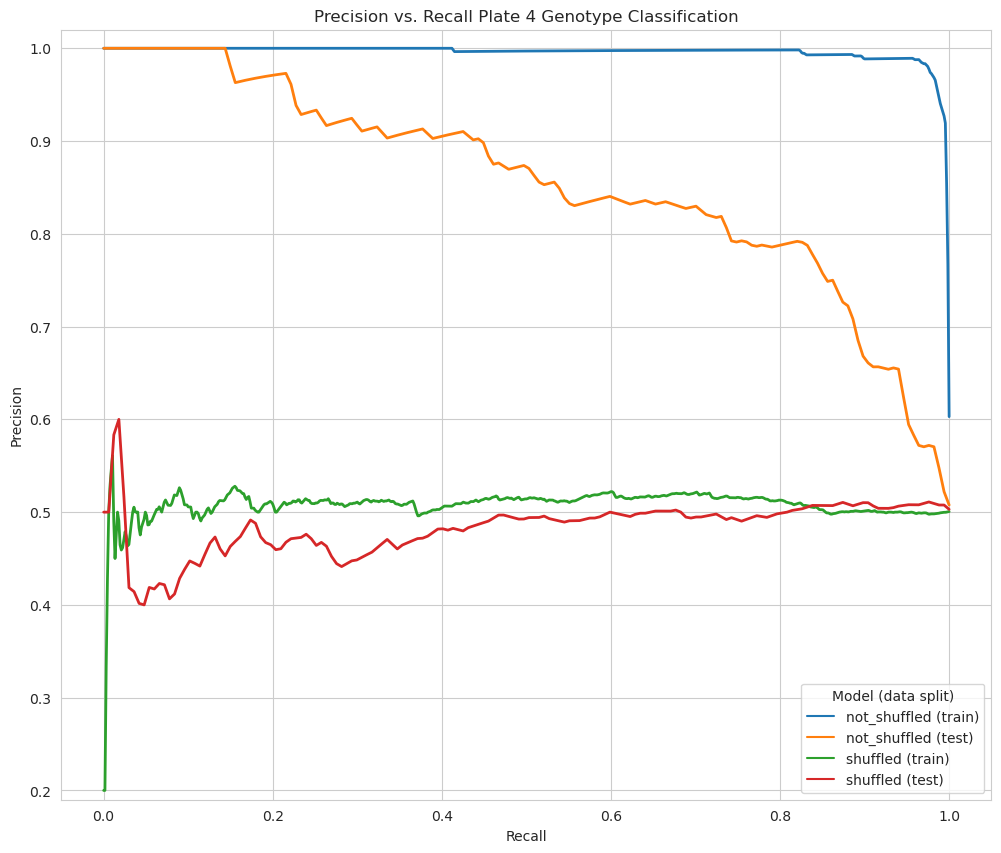

In [8]:
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

data_splitdf["plot_group"] = data_splitdf["model_type"] + " (" + data_splitdf["split_type"] + ")"

sns.lineplot(data=data_splitdf, x="recall", y="precision", hue="plot_group", ci=None, linewidth=2)

plt.legend(loc="lower right", title="Model (data split)")
plt.ylim(bottom=0.19, top=1.02)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs. Recall Plate 4 Genotype Classification")
plt.savefig(f"{fig_path}/precision_recall_plate4.png")